In [3]:
import PIL 
from PIL import Image, ImageFilter
import copy
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
class Fundus():
    # Constructor
    def __init__(self, initarg=False, **kwargs):
        
        if isinstance(initarg, str):
            self.image = self.image_from_file(initarg)
        
        if isinstance(initarg, np.ndarray):
            self.image = self.image_from_pixels(initarg, **kwargs)
        
        # Getting number of pixels
        self.npixels = np.prod(self.image.size)
        self.size = self.image.size
        self.c = self.image.getbands()
        self.c_size = len(self.c)
        self.palette, self.counts = self.get_palette()
        
    # Constructor from file
    def image_from_file(self, path):
        return Image.open(path)
    
    def image_from_pixels(self, pixels, **kwargs):
        arr = np.resize(pixels, (w, h, 3)).astype(np.uint8)
        return Image.fromarray(arr)
    
    # Get numpy array for the image
    def get_array(self):
        return np.asanyarray(self.image)
    
    # Get channel numpy array 
    def get_channels_asarray(self):
        r, g, b = self.image.split()
        return np.asanyarray(r), np.asanyarray(g), np.asanyarray(b)
    
    # Get an scpecific channel as an array
    def get_channel(self, channel):
        return np.asanyarray(self.image.getchannel(channel))
    
    # Transforme the image to a list of pixels
    def get_pixels(self):
        return np.resize(self.get_array(), (self.npixels, self.c_size))
    
    # Get a unique list of pixels amd their counts (palette)
    def get_palette(self):
        ps = np.sort(self.get_pixels(), axis=0)
        return np.unique(ps, return_counts=True, axis=0)
                         
    # Plot color counts
    def plot_counts(self):
        # Configure subplots
        f, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
        sns.despine(left=True)
                
        # Plot
        # TODO:  change xlabels to colors
        sns.lineplot(data=self.counts, ax=ax[0])
        sns.lineplot(data=np.sort(self.counts), ax=ax[1])
        
        # Title
        ax[0].set_title("Color sorted")
        ax[1].set_title("Count sorted")
    
    def color_bar(self, colors):
        cmap = mpl.colors.ListedColormap(colors)
        
        # Get hex values for 
        hexcol = np.array([mpl.colors.rgb2hex(x) for x in colors])
        
        # Get figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 2))
        fig.subplots_adjust(bottom=0.25)
        
        # Calculate bounds
        bounds = range(cmap.N + 1)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
        # Plot color bar
        bar = mpl.colorbar.ColorbarBase(ax=ax,
                                       cmap=cmap,
                                       norm=norm,
                                       boundaries=bounds,
                                       extend="neither",
                                       ticks=None,
                                       ticklocation="top",
                                       drawedges=False,
                                       spacing="uniform",
                                       filled=True,
                                       orientation="horizontal")
        bar.set_ticklabels(hexcol)
        
    
    def plot_palette(self):        
        # Transform 0-255 RGB to 0-1 RGB
        colors = self.palette/255
        
        # plot color bar
        self.color_bar(colors)
    
    
    def plot_cbar(self, nc=5):        
        # Transform 0-255 RGB to 0-1 RGB
        colors = self.palette[np.argsort(self.counts)[::-1][0:nc]]/255
        
        # Plot color bar
        self.color_bar(colors)
    

    # Plots histogram of all color chanels separately and alltogether
    def plot_histogram(self):
        # Set figure
        sns.set(style="white", palette="muted", color_codes=True)
        fig, ax = plt.subplots(2, 2, figsize=(12, 12), sharex=True)
        sns.despine(left=True)
        
        R,G,B = self.get_pixels().T
        
        # Plot  00,01 and 10 (separate channels)
        sns.distplot(R, color="r", ax=ax[0, 0])
        sns.distplot(G, color="g", ax=ax[0, 1])
        sns.distplot(B, color="b", ax=ax[1, 0])
               
        # Plot the 3 distributions together
        sns.distplot(R, color="r", hist=False, kde_kws={"shade": True}, ax=ax[1, 1])
        sns.distplot(G, color="g", hist=False, kde_kws={"shade": True}, ax=ax[1, 1])
        sns.distplot(B, color="b", hist=False, kde_kws={"shade": True}, ax=ax[1, 1])

    def plot_lines(self):
        # Plot color distribution of oroginal image
        fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=True)
        sns.despine(left=True)
        
        # Get list of all pixels
        pixels_sorted = np.sort(self.get_pixels(), axis=0)
        ax[0].plot(pixels_sorted)
        ax[0].set_title("All pixels")

        ax[1].plot(self.get_palette()[0])
        ax[1].set_title("Unique pixels")
        
    def get_summary(self):
        df_palette = pd.DataFrame(self.palette, columns=self.c)
        df_summary = pd.DataFrame()
        df_summary["mean"]  = df_palette.mean()
        df_summary["std"]  = df_palette.std()
        df_summary["var"]  = df_palette.var()
        df_summary["max-min"]  = df_palette.max()-df_palette.min()
        
        return df_summary
    
    def remove_pixels(self, colors2remove):
        """
        Takes the code of a color in RGB 0-255 format
        and blackens all the pixels of such color.
        """
        pixels = self.get_pixels()
        for color in colors2remove:
            pixels[(original.get_pixels() == color).all(axis=1)] = 0 # <- 255 RGB code for black 
            
        return pixels
        

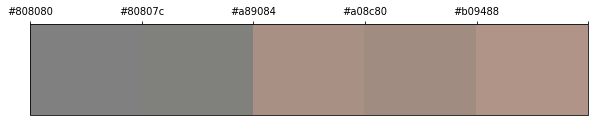

In [5]:
# Read Image, create fundus object
original = Fundus("highscore_pictures/male/male_rank_0.png")
original.plot_cbar(5)

In [6]:
palette, counts = original.get_palette()
palette_sorted = palette[np.argsort(counts)[::-1]]
arr_new = original.remove_pixels(palette_sorted[:5])

# Here we start modifying the image

In [7]:
# Generate new figure
#newimage = np.resize(arr_new, (original.size[1], original.size[0], original.c_size)).astype(np.uint8)
#print (original.size[1])
#print (original.size[0])
Fundus(arr_new, w=original.size[0], h=original.size[1] )

NameError: name 'w' is not defined

In [6]:
import scipy.cluster.hierarchy as shc

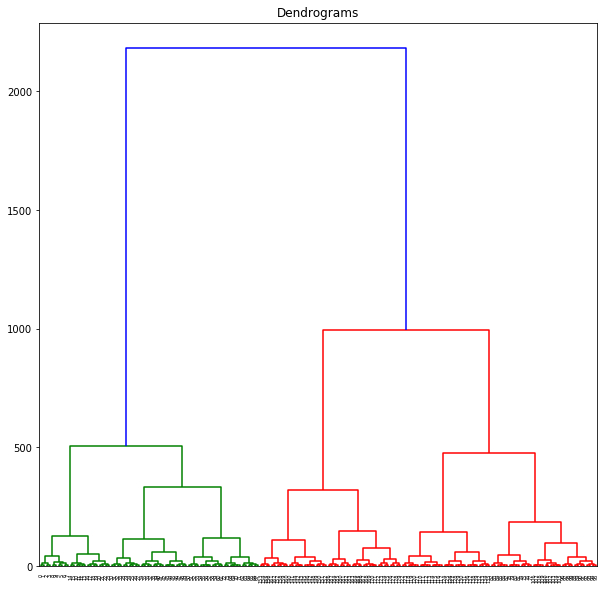

In [7]:
plt.figure(figsize=(10, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(palette, method='ward'))

In [28]:
import sklearn
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=14, affinity='euclidean', linkage='ward')  
cluster.fit_predict(palette)

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  8,  8,  8,  8,  8,  8,  8,
        8])

In [60]:
len(cluster.fit_predict(palette))
palette[cluster.fit_predict(palette)==10]

array([[ 0,  0, 20],
       [ 0,  0, 24],
       [ 0,  0, 28],
       [ 0,  0, 32],
       [ 0,  0, 36],
       [ 0,  0, 40],
       [ 0,  0, 44],
       [ 0,  0, 48],
       [ 0,  0, 52],
       [ 0,  0, 56]], dtype=uint8)